# Long Short US Sectors using Structural Entropy

## Introduction

Based on previous article [Structural Entropy](https://medium.com/dev-genius/hedging-long-only-portfolios-using-structural-entropy-e53d71330370), this article attempts to test the performance of a long short strategy on US sectors using structural entropy. Ideally it should use liquid US sector futures since data is unavailable (atleast for free), it uses ETFs as proxy.

The assumption in previous article (referenced above), was that when entropy is low there is contagion in the market and we identify it as a volatile and downtrending market. While this works for a diversified index like S&P500, sectors are usually a concentrated index of related securities and hence in this article we use both the entropy and historical returns (+ve/-ve) as a trend indicator.

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Data

Load securities that make up S&P500 and their sector information. We drop Real Estate sector because it has too few securities.

Note: There is survivorship bias here cause we use the latest S&P500 composition.

In [4]:
sp500stocks = pd.read_csv("SP500.csv", header=None)

In [5]:
sectors = sp500stocks[1].unique().tolist()

In [6]:
sectors.remove('Real Estate')

In [7]:
sectors

['Industrials',
 'Health Care',
 'Information Technology',
 'Communication Services',
 'Consumer Staples',
 'Consumer Discretionary',
 'Utilities',
 'Financials',
 'Materials',
 'Energy']

In [8]:
def get_sector_stocks(sector_name, df):
    return df.loc[df[1] == sector_name, 0].tolist()

def get_sector_returns(sector_stocks):
    prices = yf.download(sector_stocks, start="2010-01-01", end="2022-11-20")['Adj Close']
    returns = prices.dropna(axis=1).resample('W').last().pct_change().fillna(0)
    log_returns = returns.apply(np.log1p)
    return returns, log_returns

sector_etfs = { 'Materials' : 'XLB', 'Communication Services' : 'XLC', 'Consumer Discretionary' : 'XLY',
                'Consumer Staples' : 'XLP', 'Energy' : 'XLE', 'Financials' : 'XLF',
                'Health Care' : 'XLV', 'Industrials' : 'XLI', 'Information Technology' : 'XLK', 'Utilities' : 'XLU' }

Next, we compute the returns and log returns for all stocks in each sector and the sector ETF as well.

In [9]:
returns = {}
log_returns = {}

for sector in sectors:
    stocks = get_sector_stocks(sector, sp500stocks)
    r, lr = get_sector_returns(stocks)
    returns[sector] = r
    log_returns[sector] = lr

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  64 of 64 completed
[*********************100%***********************]  75 of 75 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  32 of 32 completed
[*********************100%***********************]  56 of 56 completed
[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  66 of 66 completed
[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  23 of 23 completed


In [10]:
spy_prices = yf.download(['SPY'], start="2010-01-01", end="2022-11-20")['Adj Close']
spy_returns = spy_prices.resample('W').last().pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


In [11]:
sector_returns = None

for sector in sector_etfs:
    prices = yf.download(sector_etfs[sector], start="2010-01-01", end="2022-11-20")['Adj Close']
    r = prices.resample('W').last().pct_change().fillna(0)
    r.name = sector
    if sector_returns is None:
        sector_returns = r.to_frame()
    else:
        sector_returns[sector] = r

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Structural Entropy

We then proceed to compute structural entropy for each sector for different window lengths. This is again as explained in previous article to capture the trend in entropy.

In [12]:
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings
from sklearn.covariance import EmpiricalCovariance as EC
from sklearn.preprocessing import StandardScaler

def checkDesignMatrix(X):
    try:
        assert isinstance(X, (np.ndarray, pd.DataFrame, pd.Series))
    except AssertionError:
        raise
        sys.exit(1)

    X = np.asarray(X, dtype=float)
    X = np.atleast_2d(X)
    T, N = X.shape
    transpose_flag = False
    return T, N, transpose_flag
        
        
def marcenkoPastur(X):
    T, N, _ = checkDesignMatrix(X)
    q = N / float(T)

    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho


def clipped(X, alpha=None, return_covariance=False):
    try:
        if alpha is not None:
            assert isinstance(alpha, Real) and 0 <= alpha <= 1
            
        assert isinstance(return_covariance, bool)
    except AssertionError:
        raise
        sys.exit(1)
    
    T, N, transpose_flag = checkDesignMatrix(X)
    if transpose_flag:
        X = X.T
        
    if not return_covariance:
        X = StandardScaler(with_mean=False,
                           with_std=True).fit_transform(X)

    ec = EC(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    E = ec.covariance_
    
    if return_covariance:
        inverse_std = 1./np.sqrt(np.diag(E))
        E *= inverse_std
        E *= inverse_std.reshape(-1, 1)

    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T

    if alpha is None:
        (lambda_min, lambda_max), _ = marcenkoPastur(X)
        xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)
    else:
        xi_clipped = np.full(N, np.nan)
        threshold = int(ceil(alpha * N))
        if threshold > 0:
            xi_clipped[-threshold:] = eigvals[-threshold:]

    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    E_clipped = np.zeros((N, N), dtype=float)
    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)
        
    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)
    
    if return_covariance:
      std = 1./inverse_std
      E_clipped *= std
      E_clipped *= std.reshape(-1, 1)

    return E_clipped

In [13]:
from scipy.sparse.csgraph import connected_components
import scipy as sp

def graph_entropy(C, cutoff):
    C = (np.abs(C)> cutoff).astype(int)
    # graph entropy
    _, labels = connected_components(C)
    counts = np.unique(labels, return_counts=True)[1]
    probs = counts / np.sum(counts)
    if len(counts) > 1:
        entropy = sp.stats.entropy(probs) / np.log(len(counts))
    else:
        entropy = 0.0
    return entropy    

def structural_entropy(df, lags):
    entropy_df = pd.DataFrame(index=df.index)
    
    for i in tqdm(range(max(lags), df.shape[0])):
        for lag in lags:
            X = df.iloc[i-lag:i+1] # i+1 because it is exclusive
            C = clipped(X.values)
            mr = X.sum(axis=0).mean()
            
            if mr >= 0:
                entropy_df.loc[df.index[i], str(lag)] = graph_entropy(C, 0.6)
            else:
                entropy_df.loc[df.index[i], str(lag)] = -graph_entropy(C, 0.6)
    return entropy_df

In [14]:
entropy_df = {}

for sector in sectors:
    entropy_df[sector] = structural_entropy(log_returns[sector], lags=[60, 50, 40, 30])

100%|███████████████████████████████████████████████████████████████████████████████| 612/612 [00:04<00:00, 138.06it/s]


## Forecasted entropy

We use the average difference in entropy between lags for each sector as the forecasted trend in entropy.

In [15]:
signals = {}

for sector in sectors:
    entropy_mean = entropy_df[sector].dropna(axis=0).diff(axis=1).dropna(axis=1)
    signal = entropy_mean.mean(axis=1).divide(entropy_mean.std(axis=1))
    signals[sector] = signal
    signals[sector].name = sector

In [16]:
signals_df = pd.concat(list(signals.values()), join='inner', axis=1)
signals_df.shape

(612, 10)

## Trading Strategy

For each week, we get the forecasted entropy score (entropy multiplied by positive or negative return) for a sector and pick the sector with the highest score to long and also pick the sector with the smallest score to short.

In [29]:
weights = np.zeros(signals_df.shape)
weights = pd.DataFrame(weights, index=signals_df.index, columns=signals_df.columns)


for i in range(0, signals_df.shape[0]):
    e = signals_df.iloc[i, :]
    e.replace([np.inf, -np.inf], np.nan, inplace=True)
    e = e.dropna(axis=0)
    pe = e[e > 0]
    ne = e[e < 0]
    
    if len(pe) > 0 and len(ne) > 0:
        weights.loc[signals_df.index[i], pe.nlargest(1).index] =  1
        weights.loc[signals_df.index[i], ne.nsmallest(1).index] = -1

In [30]:
port_ret = weights.shift(1).multiply(sector_returns)

## Backtest results

<AxesSubplot:xlabel='Date'>

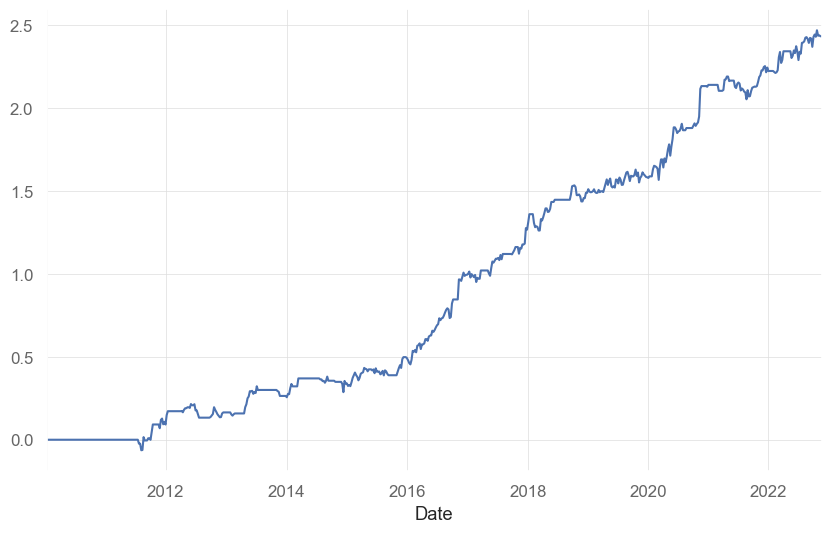

In [31]:
pnl = port_ret.sum(axis=1)
pnl.cumsum(axis=0).plot()

                           Strategy
-------------------------  ----------
Start Period               2010-01-10
End Period                 2022-11-20
Risk-Free Rate             0.0%
Time in Market             59.0%

Cumulative Return          874.55%
CAGR﹪                     19.35%

Sharpe                     2.66
Prob. Sharpe Ratio         100.0%
Smart Sharpe               2.48
Sortino                    4.96
Smart Sortino              4.63
Sortino/√2                 3.51
Smart Sortino/√2           3.27
Omega                      1.83

Max Drawdown               -13.12%
Longest DD Days            336
Volatility (ann.)          34.35%
Calmar                     1.47
Skew                       1.28
Kurtosis                   7.72

Expected Daily %           0.34%
Expected Monthly %         1.48%
Expected Yearly %          19.14%
Kelly Criterion            26.69%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.2%
Expected Shortfall (cVaR)  -3.2%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-09,2021-08-22,2021-11-21,196,-13.124710,-11.836302
2,2018-02-11,2018-03-11,2018-04-15,63,-9.586060,-9.584020
3,2018-10-21,2018-11-25,2019-04-21,182,-9.404424,-7.610246
4,2014-09-14,2014-12-14,2015-02-15,154,-9.116851,-6.001870
5,2020-02-16,2020-03-08,2020-03-22,35,-8.392160,-1.782187


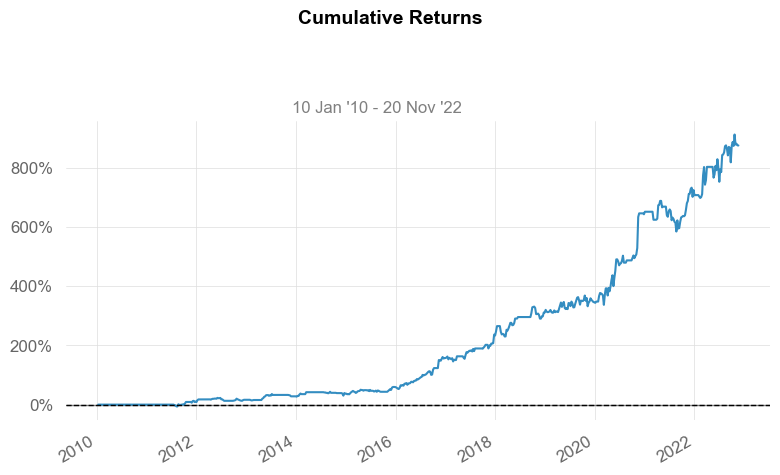

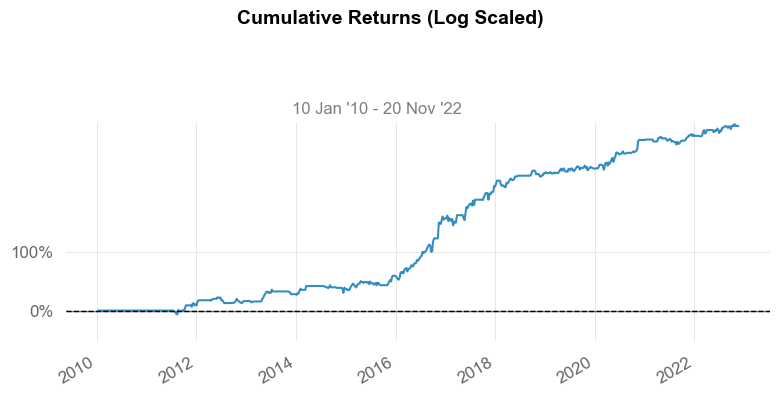

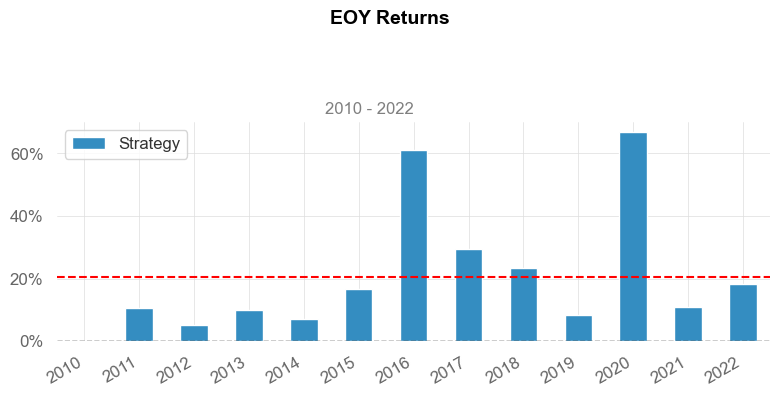

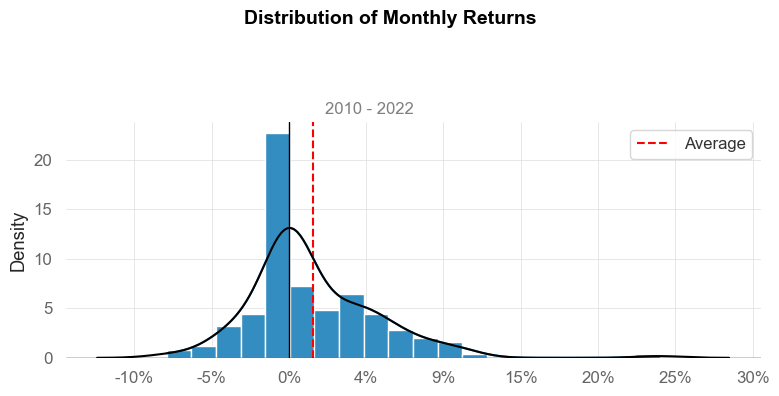

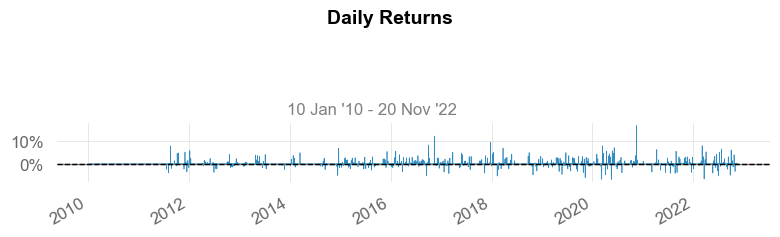

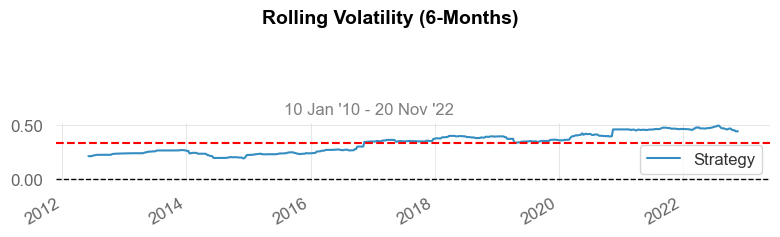

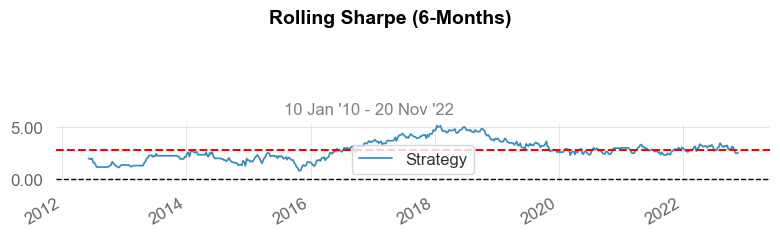

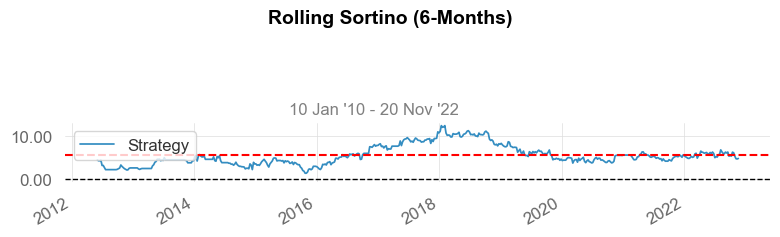

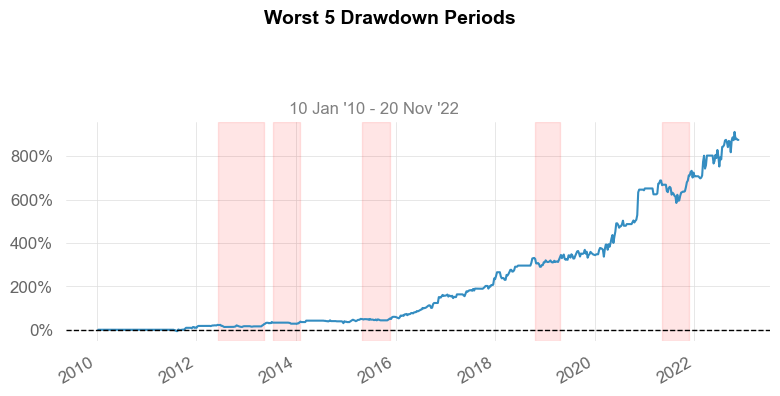

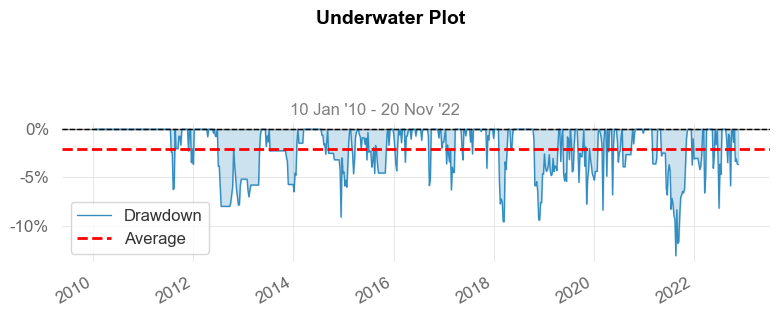

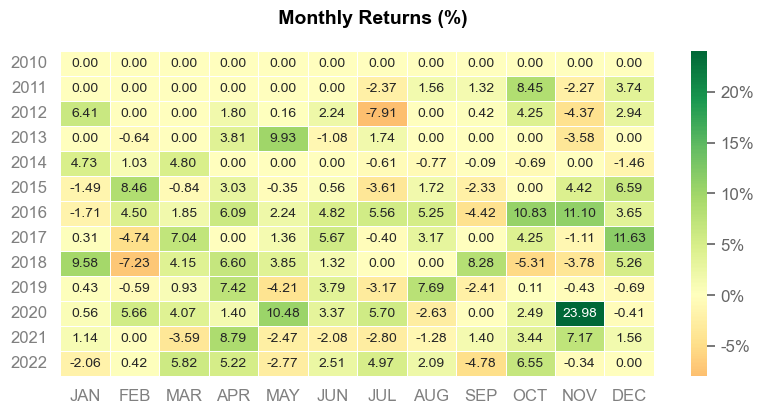

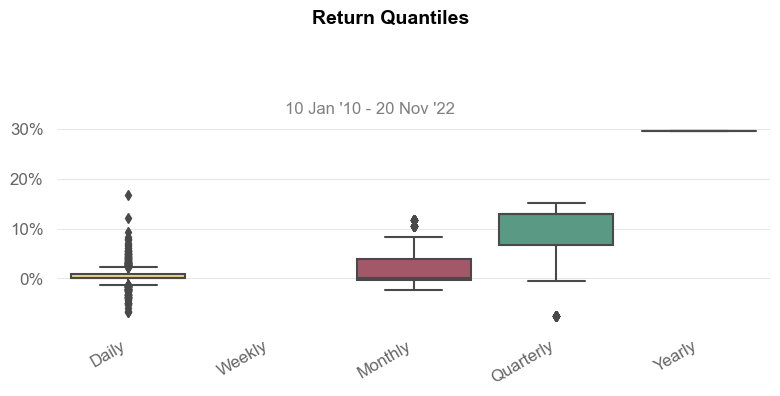

In [32]:
import quantstats as qs
qs.reports.full(pnl)

#### Things to improve

1. Fetch US Sector futures data (rolling)
2. Fetch US Sector future underlying weights
3. Multiply returns by weight before computing correlations and entropy
4. Try different cutoffs for entropy (0.6, 0.7, 0.8)
5. Compute structural entropy of market (SPY) and don't trade during market downturns.